In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [231]:
enrichment_file = "fgsea"
# enrichment_file = "gprofiler"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Actually, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results. 
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

enr["name"] = enr["native"]

In [232]:
# enr = enr[enr["source"] == "GO_Molecular_Function_2021"] # Molecular function
# enr = enr[enr["source"] == "GO_Cellular_Component_2021"] # Cellular component
# enr = enr[enr["source"] == "GO_Biological_Process_2021"] # Biological process
# enr = enr[enr["source"] == "KEGG_2021_Human"] # KEGG pathways
# enr = enr[enr["source"] == "Reactome_2016"] # Reactome pathways
enr = enr[enr["source"] == "PanglaoDB_Augmented_2021"] # Cell types

In [233]:
enr = enr[enr["p_value"] < .05]

In [234]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [235]:
enr.head()

,native,p_value,padj,ES,NES,nMoreExtreme,size,dim,method,source,name,minlogp
8405,B Cells,0.001271,0.054450,0.896699,1.485698,0,44,0,mofa,PanglaoDB_Augmented_2021,B Cells,2.895975
8406,B Cells Memory,0.002740,0.054450,0.929249,1.448481,1,28,0,mofa,PanglaoDB_Augmented_2021,B Cells Memory,2.562293
8407,B Cells Naive,0.001319,0.054450,0.891552,1.447116,0,35,0,mofa,PanglaoDB_Augmented_2021,B Cells Naive,2.879669
8416,Decidual Cells,0.007220,0.083935,-0.891624,-1.560865,1,24,0,mofa,PanglaoDB_Augmented_2021,Decidual Cells,2.141450
8417,Dendritic Cells,0.039241,0.260669,0.786072,1.319408,30,51,0,mofa,PanglaoDB_Augmented_2021,Dendritic Cells,1.406265


## Count enrichments

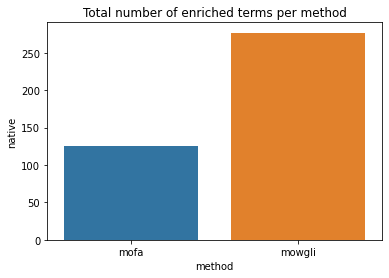

In [236]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

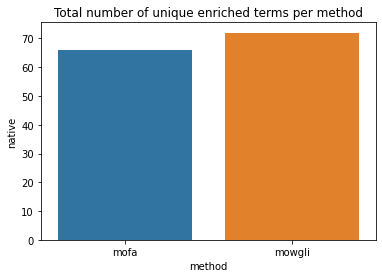

In [237]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

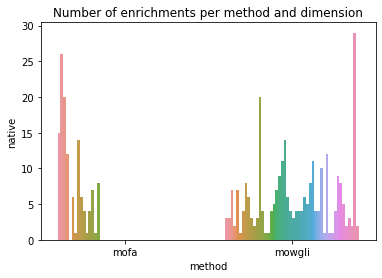

In [238]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

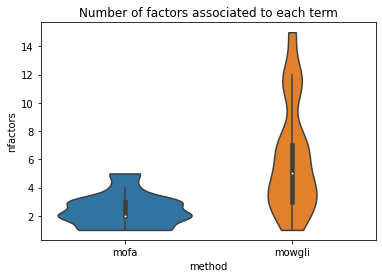

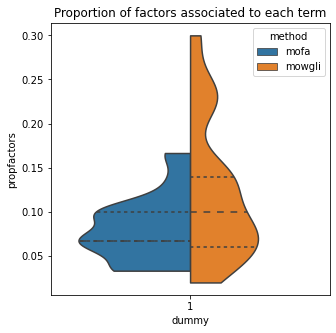

In [239]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors", cut=0)
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 30
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(
    data=enr,
    x="dummy",
    hue="method",
    y="propfactors",
    split=True,
    ax=ax,
    inner="quart",
    cut=0,
)
plt.show()


In [240]:
selectivity_mofa = (enr[enr["method"] == "mofa"]["native"].nunique() + 30) / (2*enr[enr["method"] == "mofa"]["native"].count())
selectivity_mowgli = (enr[enr["method"] == "mowgli"]["native"].nunique() + 50) / (2*enr[enr["method"] == "mowgli"]["native"].count())
print("Selectivity of MOFA+: {:.4f}".format(selectivity_mofa))
print("Selectivity of Mowgli: {:.4f}".format(selectivity_mowgli))

Selectivity of MOFA+: 0.3840
Selectivity of Mowgli: 0.2202


## Biology-driven check

In [241]:
enr.head()

,native,method,p_value,padj,ES,NES,nMoreExtreme,size,dim,source,name,minlogp,nfactors,ndim,propfactors,dummy
0,B Cells,mofa,0.001271,0.054450,0.896699,1.485698,0,44,0,PanglaoDB_Augmented_2021,B Cells,2.895975,2,30,0.066667,1
1,B Cells Memory,mofa,0.002740,0.054450,0.929249,1.448481,1,28,0,PanglaoDB_Augmented_2021,B Cells Memory,2.562293,2,30,0.066667,1
2,B Cells Naive,mofa,0.001319,0.054450,0.891552,1.447116,0,35,0,PanglaoDB_Augmented_2021,B Cells Naive,2.879669,1,30,0.033333,1
3,Decidual Cells,mofa,0.007220,0.083935,-0.891624,-1.560865,1,24,0,PanglaoDB_Augmented_2021,Decidual Cells,2.141450,2,30,0.066667,1
4,Dendritic Cells,mofa,0.039241,0.260669,0.786072,1.319408,30,51,0,PanglaoDB_Augmented_2021,Dendritic Cells,1.406265,2,30,0.066667,1


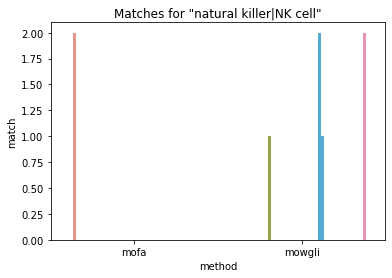

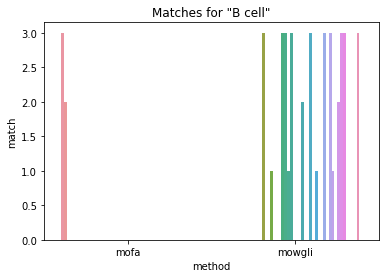

In [242]:
# TODO: check this, it seems weird
def barplot_matches(keywords, case=False):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].sum().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()


barplot_matches("natural killer|NK cell")
barplot_matches("B cell")

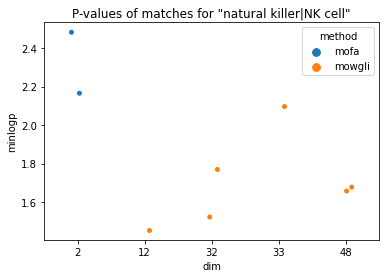

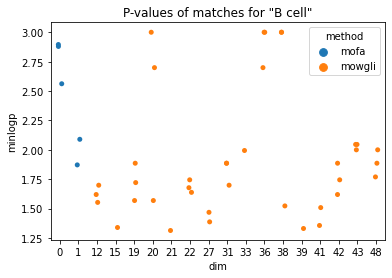

In [243]:
def stripplot_matches(keywords, case=False):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

stripplot_matches("natural killer|NK cell")
stripplot_matches("B cell")